# Personalisation and Machine Learning


## Model 3. (MSE) loss function

Korina Kyriaki Zaromytidou

Code is more explicitly  defined in the other notebooks - also with the origin of the code. 

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format','{:.5f}'.format)
np.set_printoptions(suppress=True)
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError, MeanAbsolutePercentageError

Duplicate ratings found by the same user for the following books:
         user_id              book_title
31         11676  The Kitchen God's Wife
36         49635  The Kitchen God's Wife
112        11676           The Testament
140        31315           The Testament
3397      183187                Airframe
...          ...                     ...
1027523   271988               El Medico
1027524   271988               El Medico
1028246   274061       Too Hot To Handle
1028521   274301      Multiple Sclerosis
1028547   274301      Multiple Sclerosis

[1969 rows x 2 columns]
There are no missing values in the 'book_title' column.
There are no zeros in the 'book_title' column.


/var/folders/dc/jjj3rhz5677f3g14zjfccdr80000gn/T/ipykernel_53176/1729752464.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_rating = df.groupby('book_title').mean()['rating'].reset_index()


Size of user_id column: 381874
Unique user IDs: [    9    10    11 ... 68082 68083 68084]
Number of users: 5000
Number of books: 68189
Min rating: 1.0
Max rating: 10.0


/var/folders/dc/jjj3rhz5677f3g14zjfccdr80000gn/T/ipykernel_53176/1729752464.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["user"] = df_subset["user_id"].map(user2user_encoded)
/var/folders/dc/jjj3rhz5677f3g14zjfccdr80000gn/T/ipykernel_53176/1729752464.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["book"] = df_subset["book_id"].map(book2book_encoded)
/var/folders/dc/jjj3rhz5677f3g14zjfccdr80000gn/T/ipykernel_53176/1729752464.py:66: SettingWithCopyWarning: 
A value is trying 

Epoch 1/5
1864/1864 [==============================] - 103s 55ms/step - loss: 4.9945 - mae: 1.5576 - val_loss: 2.4941 - val_mae: 1.2093
Epoch 2/5
1864/1864 [==============================] - 103s 55ms/step - loss: 2.1191 - mae: 1.0848 - val_loss: 2.6306 - val_mae: 1.2493
Epoch 3/5
1864/1864 [==============================] - 104s 56ms/step - loss: 1.7317 - mae: 0.9636 - val_loss: 2.6723 - val_mae: 1.2348
Epoch 4/5
1864/1864 [==============================] - 104s 56ms/step - loss: 1.5034 - mae: 0.8835 - val_loss: 2.8260 - val_mae: 1.2599
Epoch 5/5
1864/1864 [==============================] - 105s 56ms/step - loss: 1.3628 - mae: 0.8337 - val_loss: 2.8660 - val_mae: 1.2611


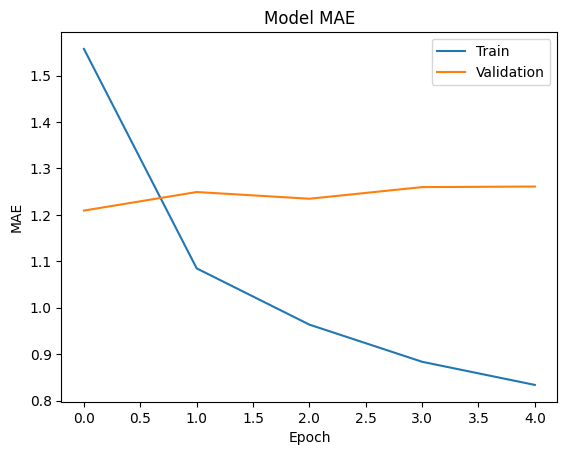

In [3]:
# Importing the dataset
data = pd.read_csv('data/Preprocessed_data.csv')
pd.options.display.max_columns = 150
data = data[(data['rating'] != 0) & (~data['rating'].isnull())]
duplicate_ratings = data[data.duplicated(subset=['user_id', 'book_title'], keep=False)]

if len(duplicate_ratings) > 0:
    print("Duplicate ratings found by the same user for the following books:")
    print(duplicate_ratings[['user_id', 'book_title']])
else:
    print("No duplicate ratings found.")
# Droping duplicates 
new_data = data.drop_duplicates(subset=['user_id', 'book_title'], keep=False)
df = new_data.drop(index=new_data[new_data['rating'] == 0].index)

missing_values = new_data['book_title'].isnull().sum()
zeros_count = (new_data['book_title'] == 0).sum()
# Exploring for  missing values 
if missing_values > 0:
    print("There are", missing_values, "missing values in the 'book_title' column.")
else:
    print("There are no missing values in the 'book_title' column.")

if zeros_count > 0:
    print("There are", zeros_count, "zeros in the 'book_title' column.")
else:
    print("There are no zeros in the 'book_title' column.")

num_rating = df.groupby('book_title').count()['rating'].reset_index()
num_rating.rename(columns={'rating': 'num_ratings'}, inplace=True)

avg_rating = df.groupby('book_title').mean()['rating'].reset_index()
avg_rating.rename(columns={'rating': 'avg_ratings'}, inplace=True)

popular = num_rating.merge(avg_rating, on='book_title')
popular_df = popular[popular['num_ratings'] >= 180].sort_values('avg_ratings', ascending=False).head(20)
popular_df = popular_df.merge(new_data, on='book_title').drop_duplicates('book_title')[['book_title', 'book_author', 'img_m', 'num_ratings', 'avg_ratings']]
# Factorise Book_title categorical data 
new_data = new_data.copy()
new_data.loc[:, 'book_id'] = pd.factorize(new_data['book_title'])[0]
new_data['user_id'] = pd.factorize(new_data['user_id'])[0]
# droping column not needed 
df = new_data.drop(['Unnamed: 0', 'location', 'isbn', 'img_s', 'img_m', 'img_l', 'Summary', 'city', 'state'], axis=1)
df = df.drop(df[df['book_id'] == 0].index)

column_size = len(df['user_id'])
print("Size of user_id column:", column_size)
unique_values = df['user_id'].unique()
print("Unique user IDs:", unique_values)
# Creating a smaller subset to help with computation 
user_ids_subset = df['user_id'].unique()[:5000]
df_subset = df[df['user_id'].isin(user_ids_subset)]

user_ids = df_subset["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
book_ids = df_subset["book_id"].unique().tolist()
book2book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded2book = {i: x for i, x in enumerate(book_ids)}

df_subset["user"] = df_subset["user_id"].map(user2user_encoded)
df_subset["book"] = df_subset["book_id"].map(book2book_encoded)

num_users = len(user2user_encoded)
num_books = len(book_encoded2book)

df_subset["rating"] = df_subset["rating"].values.astype(np.float32)
min_rating = min(df_subset["rating"])
max_rating = max(df_subset["rating"])

print("Number of users:", num_users)
print("Number of books:", num_books)
print("Min rating:", min_rating)
print("Max rating:", max_rating)

x = df_subset[["user", "book"]].values
y = df_subset["rating"].values
# Spliting the data 
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Developing the model 
embedding_size = 50
epochs = 5

user = tf.keras.Input(shape=(1,))
book = tf.keras.Input(shape=(1,))

user_embedding = layers.Embedding(num_users, embedding_size, embeddings_regularizer=keras.regularizers.l2(1e-5))(user)
user_embedding = layers.Reshape(target_shape=(embedding_size,))(user_embedding)
book_embedding = layers.Embedding(num_books, embedding_size, embeddings_regularizer=keras.regularizers.l2(1e-5))(book)
book_embedding = layers.Reshape(target_shape=(embedding_size,))(book_embedding)

concat = layers.Concatenate()([user_embedding, book_embedding])
dense1 = layers.Dense(256, activation="relu")(concat)
dropout = layers.Dropout(0.2)(dense1)
output = layers.Dense(1)(dropout)

model = tf.keras.Model(inputs=[user, book], outputs=output)
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=["mae"])

history = model.fit(x=[x_train[:, 0], x_train[:, 1]], y=y_train, batch_size=64, epochs=epochs, verbose=1, validation_data=([x_val[:, 0], x_val[:, 1]], y_val))

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [6]:
from sklearn.metrics import average_precision_score

def calculate_map(model, x, y, k):
    # Get the predicted ratings for the given inputs
    ratings = model.predict(x)

    # Initialize variables to store average precision and count of relevant items
    avg_precision = 0.0
    num_relevant = 0

    # Iterate over each user's ratings and calculate average precision
    for i in range(len(x)):
        # Sort the predicted ratings in descending order
        predicted_indices = np.argsort(ratings[i])[::-1]
        predicted_indices = predicted_indices[:k]  # Consider only top-k predictions

        # Get the ground truth ratings for the user
        ground_truth_indices = np.where(y[i] > 0)[0]

        # Create a binary relevance vector for the ground truth
        ground_truth = np.zeros(len(ratings[i]))
        ground_truth[ground_truth_indices] = 1

        # Compute average precision for the user
        avg_precision += average_precision_score(ground_truth, ratings[i])

        # Increment count of relevant items
        num_relevant += 1

    if num_relevant > 0:
        avg_precision /= num_relevant

    return avg_precision

k = 10  # Top-k predictions to consider
map_score = calculate_map(model, [x_val[:, 0], x_val[:, 1]], y_val, k)

print("Mean Average Precision (MAP) @{}: {:.4f}".format(k, map_score))


932/932 [==============================] - 1s 1ms/step
Mean Average Precision (MAP) @10: 1.0000


In [8]:
# Get the predicted ratings for the given inputs
predicted_ratings = model.predict([x_val[:, 0], x_val[:, 1]])
predicted_ratings = predicted_ratings.flatten() * (max_rating - min_rating) + min_rating

# Calculate evaluation metrics
threshold = 0.5  # Define a threshold to classify ratings as positive or negative
y_true = np.where(y_val > threshold, 1, 0)
y_pred = np.where(predicted_ratings > threshold, 1, 0)

accuracy = np.mean(y_true == y_pred)
average_precision = average_precision_score(y_true, predicted_ratings)

print("Accuracy:", accuracy)
print("Average Precision:", average_precision)


932/932 [==============================] - 2s 2ms/step
Accuracy: 1.0
Average Precision: 1.0


In [10]:
def catalog_coverage(recommended_items, catalog_items):
    unique_recommended_items = set(recommended_items.flatten())
    unique_catalog_items = set(catalog_items.flatten())

    coverage_score = len(unique_recommended_items) / len(unique_catalog_items)
    return coverage_score


recommended_items = model.predict([x_val[:, 0], x_val[:, 1]])  # Recommended item predictions from the model
catalog_items = df_subset["book"].unique()  # All available book IDs in the catalog

coverage_score = catalog_coverage(recommended_items, catalog_items)
print("Catalog Coverage: {:.2%}".format(coverage_score))


932/932 [==============================] - 1s 2ms/step
Catalog Coverage: 30.56%


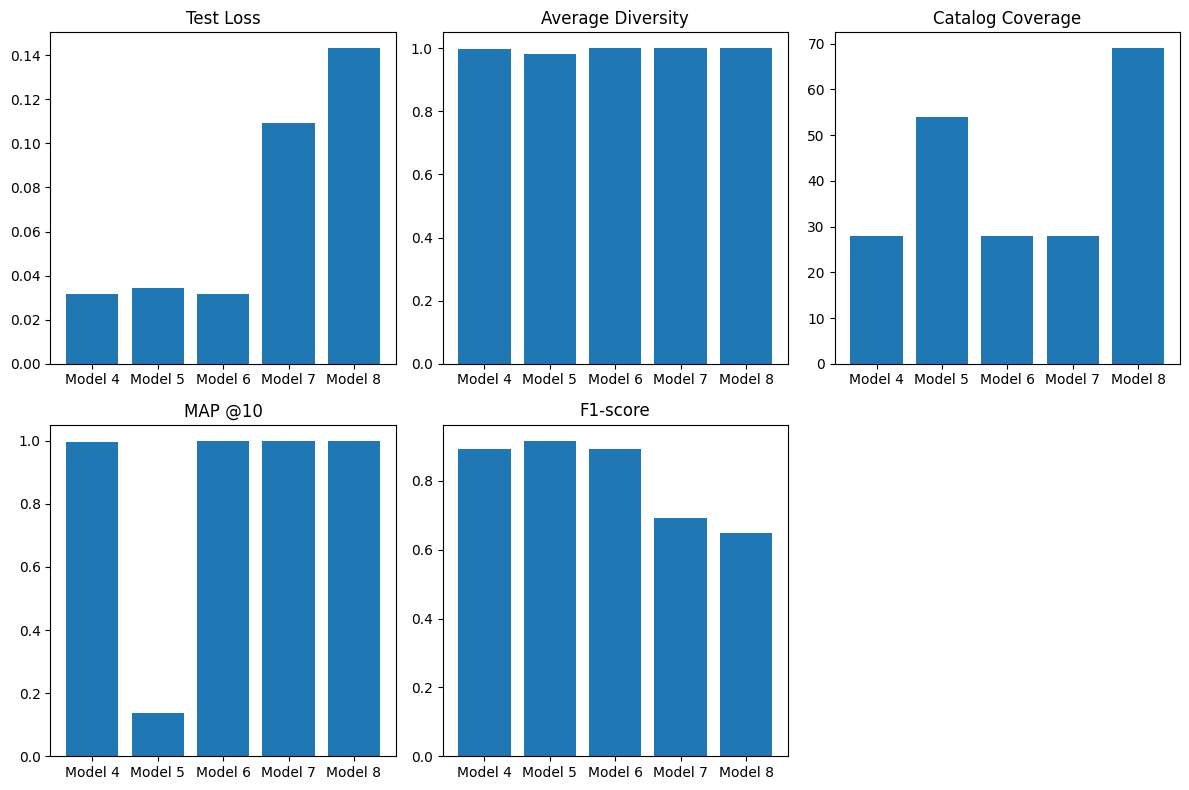

In [11]:
import matplotlib.pyplot as plt

# Evaluation metrics
test_loss = [0.0315, 0.0343, 0.0317, 0.1094, 0.1432]
average_diversity = [0.9975, 0.9829, 0.9994, 1.0000, 1.0000]
catalog_coverage = [27.94, 53.91, 27.94, 27.94, 69.02]
map_at_10 = [0.9956, 0.1357, 1.0000, 1.0000, 1.0000]
f1_score = [0.8939, 0.9173, 0.8938, 0.6933, 0.6487]

# Model labels
models = ['Model 4', 'Model 5', 'Model 6', 'Model 7', 'Model 8']

# Plotting the metrics
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.bar(models, test_loss)
plt.title('Test Loss')

plt.subplot(2, 3, 2)
plt.bar(models, average_diversity)
plt.title('Average Diversity')

plt.subplot(2, 3, 3)
plt.bar(models, catalog_coverage)
plt.title('Catalog Coverage')

plt.subplot(2, 3, 4)
plt.bar(models, map_at_10)
plt.title('MAP @10')

plt.subplot(2, 3, 5)
plt.bar(models, f1_score)
plt.title('F1-score')

plt.tight_layout()
plt.show()
